# Polynomial minimization

This examples shows how to solve a constrained polynomial minimization problem. Given p(x) and g(x), consider the problem in `x`

    min  p(x)
    s.t. g(x) >= 0
    
We can lower bound the optimal value by solving the following problem in `gamma, sigma(x)`

    max  gamma
    s.t. p(x) - gamma - sigma(x) g(x) >= 0                (1)
         sigma(x) >= 0

In [1]:
from sympy.abc import x, y
from posipoly import *

tot_deg = 6        # overall degree of problem
n = 2              # number of variables
pp_cone = 'psd'    # can be 'psd' or 'sdd'

p = Polynomial.from_sympy(-x**2 - y**2 + x, [x,y])
g = Polynomial.from_sympy(1 - x**2 - y**2, [x,y])

We introduce a dummy variable `pos(x)` and replace positivity by cone constraints.
    
    max  gamma
    s.t. p(x) - gamma - sigma(x) g(x) = pos(x)
         sigma(x) SOS/SDSOS
         pos(x)   SOS/SDSOS


In [2]:
sigma_deg = tot_deg - g.d   # degree of sigma

prob = PPP({'gamma': (1, 0, 'coef'),
            'sigma': (2, sigma_deg, 'pp'),
            'pos': (2, tot_deg, 'pp')})

prob.add_row({'gamma': PTrans.eye(1, 0, n, tot_deg),
              'sigma': PTrans.mul_pol(n, sigma_deg, g),
              'pos': PTrans.eye(n, tot_deg)}, 
             p, 'eq')
prob.set_objective({'gamma': [-1]})

_, status = prob.solve(pp_cone) 

opt_gamma = prob.get_poly('gamma')(0)

print('a lower bound is {:.2f}'.format(opt_gamma))

a lower bound is -2.00


<IPython.core.display.Javascript object>


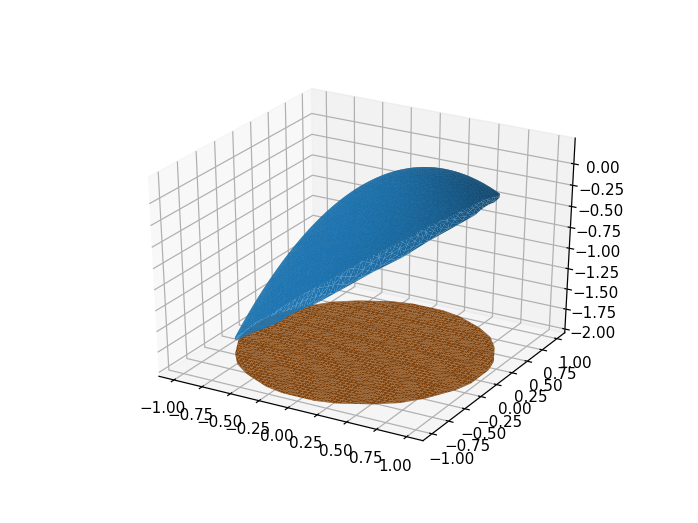

In [3]:
# plot polynomial for comparison
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

XX, YY = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
XX = XX.flatten()
YY = YY.flatten()

VV = np.vectorize(p)(XX, YY)
VV_control = opt_gamma * np.ones(VV.shape)

mask = np.vectorize(g)(XX, YY) >= 0

ax = plt.figure().gca(projection='3d')
ax.plot_trisurf(XX[mask], YY[mask], VV[mask])
ax.plot_trisurf(XX[mask], YY[mask], VV_control[mask])

plt.show()